In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [84]:
train_df = pd.read_csv('digit_train.csv')
test_df = pd.read_csv('digit_train.csv')

In [61]:
target = train_df['label']
train_df = train_df.drop('label', axis=1)

target.value_counts()


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [62]:
train_df.isna().sum().describe().T

count    784.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [63]:
test_df = test_df.iloc[:, :-1]
print(test_df.shape)
print(test_df.size)

(42000, 784)
32928000


## Noramlizing to a range of [0,1]

In [64]:
train_df = train_df / 255.0
test_df = test_df / 255.0

In [65]:
train_df = train_df.values.reshape(-1, 28, 28, 1)
test_df = test_df.values.reshape(-1, 28, 28, 1)

In [18]:
target = to_categorical(target, num_classes = 10)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(train_df, target, test_size = 0.2, random_state=42)

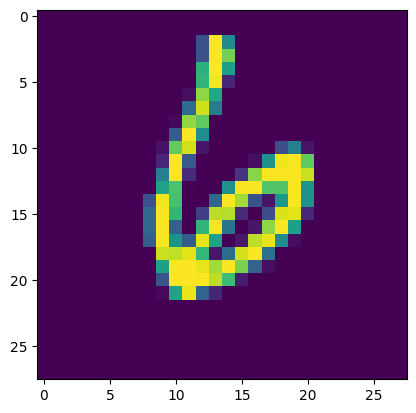

In [20]:
g = plt.imshow(x_train[0][:,:,0])

# Convo2D Usage:
1. In Convolutional Neural Networks (CNNs) for tasks like image classification, object detection, and image segmentation.
2. At the beginning of the model to extract features from images (like edges, textures, etc.).

# MaxPool2D Usage:
1. After Conv2D layers to reduce the spatial dimensions of the feature maps while preserving the most important features.
2. When you want to reduce the number of parameters and computational cost of the model.

# Flatten
1. This converts the 2D matrix of features into a 1D vector. This is necessary before feeding the data into fully connected (dense) layers, as these layers expect 1D input.

In [28]:
from keras.optimizers import RMSprop
layer = Sequential()

layer.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
layer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
layer.add(MaxPool2D(pool_size = (2, 2)))
layer.add(Dropout(0.25))

layer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
layer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
layer.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
layer.add(Dropout(0.25))

layer.add(Flatten())
layer.add(Dense(256, activation = "relu"))
layer.add(Dropout(0.5))
layer.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(learning_rate = 0.001, rho = 0.9, epsilon = 1e-08)

layer.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

ReduceLROnPlateau is used to reduce the learning rate when there is no improve in the val_acc

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5)

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [38]:
model = layer.fit(datagen.flow(x_train, y_train, batch_size=90), epochs = 1, validation_data = (x_test, y_test), verbose = 1, steps_per_epoch=x_train.shape[0] , callbacks=[learning_rate_reduction])

  374/33600 [..............................] - ETA: 1:09:16 - loss: 0.0775 - accuracy: 0.9770WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 33600 batches). You may need to use the repeat() function when building your dataset.


33600/33600 [==============================] - 50s 1ms/step - loss: 0.0775 - accuracy: 0.9770 - val_loss: 0.0266 - val_accuracy: 0.9913 - lr: 0.0010


In [79]:
result =layer.predict(test_df)

predicted_classes = np.argmax(result, axis=1)   # Convert probabilities to class labels

results = pd.Series(predicted_classes,name="Label")

1313/1313 [==============================] - 15s 11ms/step


In [88]:
# Assuming y_test is a DataFrame or Series containing the true labels
print(f"Number of predictions: {len(predicted_classes)}")
y_test = y_test.values if isinstance(y_test, pd.Series) else y_test


Number of predictions: 42000


In [93]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(target, predicted_classes)
print(f"Accuracy: {accuracy}")


Accuracy: 0.992452380952381
